**Import Dependencies**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import signal
import scipy.io.wavfile
import scipy.signal
from scipy.signal import butter, iirnotch, lfilter
from sys import breakpointhook
import math

**Reading text File (Data.txt)**

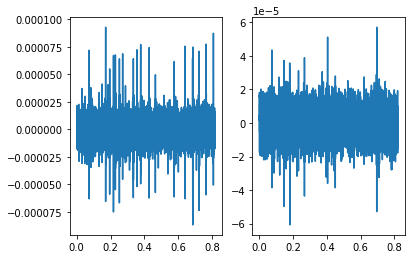

In [ ]:
plotted1 = []
plotted2 = []
xaxis1 = []
xaxis2 = []
myfile = np.loadtxt("Data.txt", dtype = float)
electrode1 = myfile[:,0]
electrode2 = myfile[:,1]
y1_elec = np.arange(len(electrode1))/24414
y2_elec = np.arange(len(electrode2))/24414
for k in range(0,20001):
    plotted1.append(electrode1[k])
for k in range(0,20001):
    plotted2.append(electrode2[k])    
y1 = np.arange(len(plotted1))/24414  
plt.subplot(1,2,1)
plt.plot(y1, plotted1)
y2 = np.arange(len(plotted2))/24414 
plt.subplot(1,2,2)
plt.plot(y2, plotted2)
plt.show()

In [ ]:
def notch_filter(cutoff, q):
    nyq = 0.5*256
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a 

def bandpass(lowcut, highcut, order=5):
    nyq = 0.5 * 256
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [ ]:
def Spike_Sorting(electrode1, electrode2):
  #Notch filter
  b,a = notch_filter(50,30)
  filteredBand1 = scipy.signal.filtfilt(b, a, electrode1)

  #Notch filter
  b,a = notch_filter(50,30)
  filteredBand2 = scipy.signal.filtfilt(b, a, electrode2)


  #Bandpass filter
  plotted_filter1 = []
  plotted_filter2 = []
  bb, aa = bandpass(0.1, 45, order=5)
  filteredBandPass1 = scipy.signal.filtfilt(bb, aa, filteredBand1)
  for k in range(0,20000,1):
      plotted_filter1.append(filteredBandPass1[k])
  y_filtered1 = np.arange(len(plotted_filter1))/24414 

  #Bandpass filter
  bb, aa = bandpass(0.1, 45, order=5)
  filteredBandPass2 = scipy.signal.filtfilt(bb, aa, filteredBand2)
  for k in range(0,20000,1):
      plotted_filter2.append(filteredBandPass2[k])
  y_filtered2 = np.arange(len(plotted_filter2))/24414 

  #Threshold 5
  samples1 = [] 
  samples2 = [] 
  for k in range(0,500,1):
      samples1.append(electrode1[k])
  thresh1 = 5 * np.std(samples1[0:499])
  for k in range(0,500,1):
      samples2.append(electrode2[k])
  thresh2 = 5 * np.std(samples2[0:499]) 
 

  #Threshold 3.5
  samples1 = [] 
  samples2 = [] 
  for k in range(0,500,1):
      samples1.append(electrode1[k])
  thresh3 = 3.5 * np.std(samples1[0:499])
  for k in range(0,500,1):
      samples2.append(electrode2[k])
  thresh4 = 3.5 * np.std(samples2[0:499]) 
  

  #Spikes_Detection_threshold_5
  elec1 = []
  elec2 = []
  Peak_timestamp = []
  k = 0
  while(k < len(electrode1)-250):
      if(electrode1[k+250] > thresh1):
          elec1.append(electrode1[k:k+500])
          Peak_timestamp.append(y1_elec[k+250])
          k = k + 500
      else:
          k = k+1
        
  k = 0        
  while(k < len(electrode2)-500):
      if(electrode2[k+250] > thresh2):
          elec2.append(electrode2[k:k+500])
          Peak_timestamp.append(y2_elec[k+250])
          k = k + 500
      else:
          k = k+1

  #Spikes_Detection_threshold_3.5
  elec11 = []
  elec22 = []
  k = 0
  while(k < len(electrode1)-500):
      if(electrode1[k+250] > thresh3):
          elec11.append(electrode1[k:k+500])
          Peak_timestamp.append(y1_elec[k+250])
          k = k + 500
      else:
          k = k+1
  k = 0        
  while(k < len(electrode2)-500):
      if(electrode2[k+250] > thresh4):
          elec22.append(electrode2[k:k+500])
          Peak_timestamp.append(y2_elec[k+250])
          k = k + 500
      else:
          k = k+1

  #PCA
  from sklearn.decomposition import PCA

  pca = PCA(n_components = 2)
  elec1_pca = pca.fit_transform(elec1)
  elec2_pca = pca.fit_transform(elec2)
  elec11_pca = pca.fit_transform(elec11)
  elec22_pca = pca.fit_transform(elec22)

  #Feature Space
  plt.figure(figsize=(10,10)) 
  plt.title("Electrode1-Threshold 5")
  plt.scatter(elec1_pca[:,0], elec1_pca[:,1])
  plt.figure(figsize=(10,10)) 
  plt.title("Electrode2-Threshold 5")
  plt.scatter(elec2_pca[:,0], elec2_pca[:,1]) 

  plt.figure(figsize=(10,10))  
  plt.title("Electrode1-Threshold 3.5")
  plt.scatter(elec11_pca[:,0], elec11_pca[:,1])
  plt.figure(figsize=(10,10))
  plt.title("Electrode2-Threshold 3.5")
  plt.scatter(elec22_pca[:,0], elec22_pca[:,1]) 

  #Kmeans Clustering
  from sklearn.cluster import KMeans
  kmeans1 = KMeans(n_clusters=2, init='k-means++', random_state=0).fit(elec1_pca)
  kmeans2 = KMeans(n_clusters=2, init='k-means++', random_state=0).fit(elec2_pca)
  y_kmeans1 = kmeans1.predict(elec1_pca)
  y_kmeans2 = kmeans2.predict(elec2_pca)

  kmeans11 = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(elec11_pca)
  kmeans22 = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(elec22_pca)
  y_kmeans11 = kmeans11.predict(elec11_pca)
  y_kmeans22 = kmeans22.predict(elec22_pca)

  #Marking Spikes For each electrode
  zero = []
  one = []
  raw1 = []
  for i in range(0,len(elec1),1):
    for k in range(0,len(plotted1),1):
      if(elec1[i][250] == plotted1[k]):
        if(y_kmeans1[i] == 0):
          zero.append(y1[k])
        else:
          one.append(y1[k])

  plt.figure(figsize=(20,10)) 
  plt.title("Electrode1-Threshold 5")
  plt.plot(y1,plotted1)

  plt.scatter(zero, np.ones(len(zero))*0.000075, s=50,c = 'purple', marker='*')
  plt.scatter(one, np.ones(len(one))*0.0001, s=50,c = 'yellow', marker='*')

  zero = []
  one = []
  raw1 = []
  for i in range(0,len(elec2),1):
    for k in range(0,len(plotted2),1):
      if(elec2[i][250] == plotted2[k]):
        if(y_kmeans2[i] == 0):
          zero.append(y2[k])
        else:
          one.append(y2[k])

  plt.figure(figsize=(20,10))
  plt.title("Electrode2-Threshold 5") 
  plt.plot(y2,plotted2)

  plt.scatter(zero, np.ones(len(zero))*0.000075, s=50,c = 'purple', marker='*')
  plt.scatter(one, np.ones(len(one))*0.0001, s=50,c = 'yellow', marker='*')

  zero = []
  one = []
  two = []
  raw1 = []
  for i in range(0,len(elec11),1):
    for k in range(0,len(plotted1),1):
      if(elec11[i][250] == plotted1[k]):
        if(y_kmeans11[i] == 0):
          zero.append(y1[k])
        if(y_kmeans11[i] == 1):
          one.append(y1[k])
        if(y_kmeans11[i] == 2):   
          two.append(y1[k]) 

  plt.figure(figsize=(20,10)) 
  plt.title("Electrode1-Threshold 3.5")
  plt.plot(y1,plotted1)
  # print("zero",zero)
  plt.scatter(zero, np.ones(len(zero))*0.0001, s=50,c = 'purple', marker='*')
  plt.scatter(one, np.ones(len(one))*0.00012, s=50,c = 'yellow', marker='*')
  plt.scatter(two, np.ones(len(two))*0.00015, s=50,c = 'green', marker='*')

  zero = []
  one = []
  two = []
  raw1 = []
  for i in range(0,len(elec22),1):
    for k in range(0,len(plotted2),1):
      if(elec22[i][250] == plotted2[k]):
        if(y_kmeans22[i] == 0):
          zero.append(y2[k])
        if(y_kmeans22[i] == 1):
          one.append(y2[k])
        if(y_kmeans22[i] == 2):   
          two.append(y2[k]) 

  plt.figure(figsize=(20,10))
  plt.title("Electrode2-Threshold 3.5") 
  plt.plot(y2,plotted2)

  plt.scatter(zero, np.ones(len(zero))*0.00007, s=50,c = 'purple', marker='*')
  plt.scatter(one, np.ones(len(one))*0.00008, s=50,c = 'yellow', marker='*')
  plt.scatter(two, np.ones(len(two))*0.00006, s=50,c = 'green', marker='*')

  #Average Spike of each neuron
  #Electrode1-thresh 5
  Mean_spike = []
  zeroavg1 = 0
  oneavg1 = 0
  for i in range(0,len(elec1),1):
    if(y_kmeans1[i] == 0):
      zeroavg1 = zeroavg1 + np.array(elec1[i])
    if(y_kmeans1[i] == 1):
      oneavg1 = oneavg1 + np.array(elec1[i])
  zeroavgg1 = zeroavg1 / len(zeroavg1)
  oneavgg1 = oneavg1 / len(oneavg1)

  Mean_spike.append(zeroavgg1)
  Mean_spike.append(oneavgg1)

  #Electrode2- thresh 5
  zeroavg2 = 0
  oneavg2 = 0
  for i in range(0,len(elec2),1):
    if(y_kmeans2[i] == 0):
      zeroavg2 = zeroavg2 + np.array(elec2[i])
    if(y_kmeans2[i] == 1):
      oneavg2 = oneavg2 + np.array(elec2[i])
  zeroavgg2 = zeroavg2 / len(zeroavg2)
  oneavgg2 = oneavg2 / len(oneavg2)

  Mean_spike.append(zeroavgg2)
  Mean_spike.append(oneavgg2)


  #Electrode1- thresh 3.5
  zeroavg3 = 0
  oneavg3 = 0
  twoavg3 = 0
  for i in range(0,len(elec11),1):
    if(y_kmeans11[i] == 0):
      zeroavg3 = zeroavg3 + np.array(elec11[i])
    if(y_kmeans11[i] == 1):
      oneavg3 = oneavg3 + np.array(elec11[i])
    if(y_kmeans11[i] == 2):   
      twoavg3 = twoavg3 + np.array(elec11[i]) 
  zeroavgg3 = zeroavg3 / len(zeroavg3)
  oneavgg3 = oneavg3 / len(oneavg3)
  twoavgg3 = twoavg3 / len(twoavg3)

  Mean_spike.append(zeroavgg3)
  Mean_spike.append(oneavgg3)
  Mean_spike.append(twoavgg3)


  #Electrode2- thresh 3.5
  zeroavg4 = 0
  oneavg4 = 0
  twoavg4 = 0
  for i in range(0,len(elec22),1):
    if(y_kmeans22[i] == 0):
      zeroavg4 = zeroavg4 + np.array(elec22[i])
    if(y_kmeans22[i] == 1):
      oneavg4 = oneavg4 + np.array(elec22[i])
    if(y_kmeans22[i] == 2):   
      twoavg4 = twoavg4 + np.array(elec22[i]) 
  zeroavgg4 = zeroavg4 / len(zeroavg4)
  oneavgg4 = oneavg4 / len(oneavg4)
  twoavgg4 = twoavg4 / len(twoavg4)  

  Mean_spike.append(zeroavgg4)
  Mean_spike.append(oneavgg4)
  Mean_spike.append(twoavgg4)

  plt.figure(figsize=(20,10)) 
  plt.subplot(1,4,1)
  plt.title("Neuron1-Electrode1-thresh 5")
  plt.plot(zeroavgg1, color = 'purple')
  plt.subplot(1,4,2)
  plt.title("Neuron2-Electrode1-thresh 5")
  plt.plot(oneavgg1, color = 'yellow')
  plt.subplot(1,4,3)
  plt.title("Neuron1-Electrode2-thresh 5")
  plt.plot(zeroavgg2, color = 'purple')
  plt.subplot(1,4,4)
  plt.title("Neuron2-Electrode2-thresh 5")
  plt.plot(oneavgg2, 'yellow')

  plt.figure(figsize=(20,10)) 
  plt.subplot(1,6,1)
  plt.title("Neuron1-Electrode1-thresh 3.5")
  plt.plot(zeroavgg3, 'purple')
  plt.subplot(1,6,2)
  plt.title("Neuron2-Electrode1-thresh 3.5")
  plt.plot(oneavgg3, 'yellow')
  plt.subplot(1,6,3)
  plt.title("Neuron3-Electrode1-thresh 3.5")
  plt.plot(oneavgg3, 'green')
  plt.subplot(1,6,4)
  plt.title("Neuron1-Electrode2-thresh 3.5")
  plt.plot(zeroavgg4, 'purple')
  plt.subplot(1,6,5)
  plt.title("Neuron2-Electrode2-thresh 3.5")
  plt.plot(oneavgg4, 'yellow')
  plt.subplot(1,6,6)
  plt.title("Neuron3-Electrode2-thresh 3.5")
  plt.plot(twoavgg4, 'green')

  return Mean_spike, Peak_timestamp

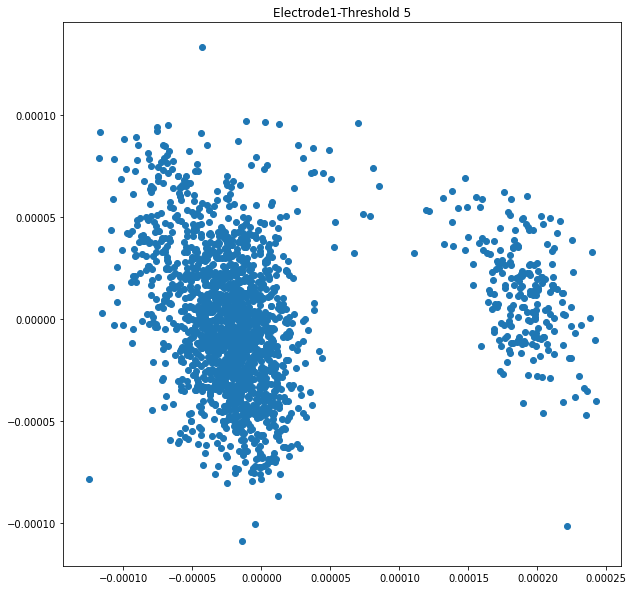

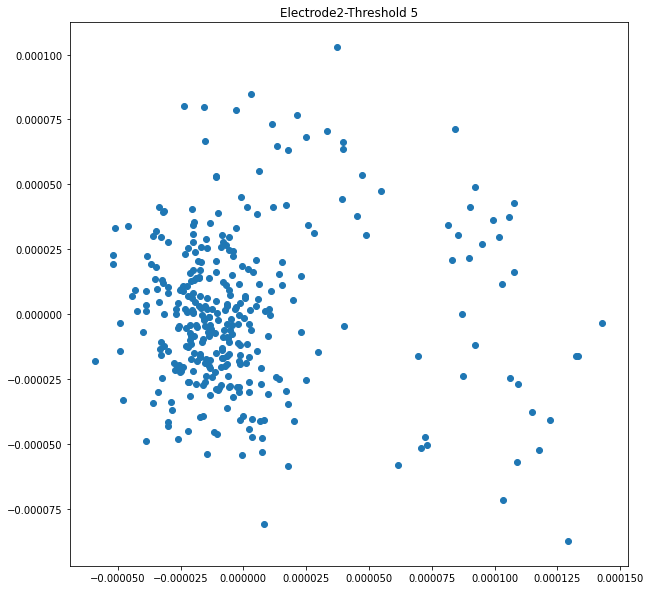

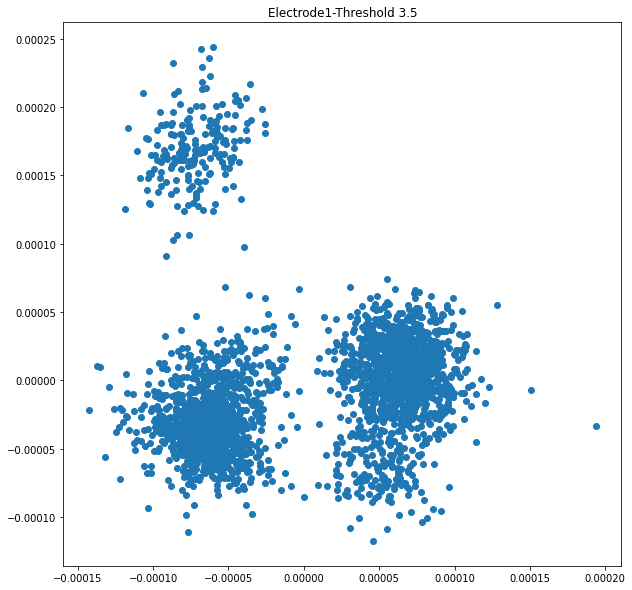

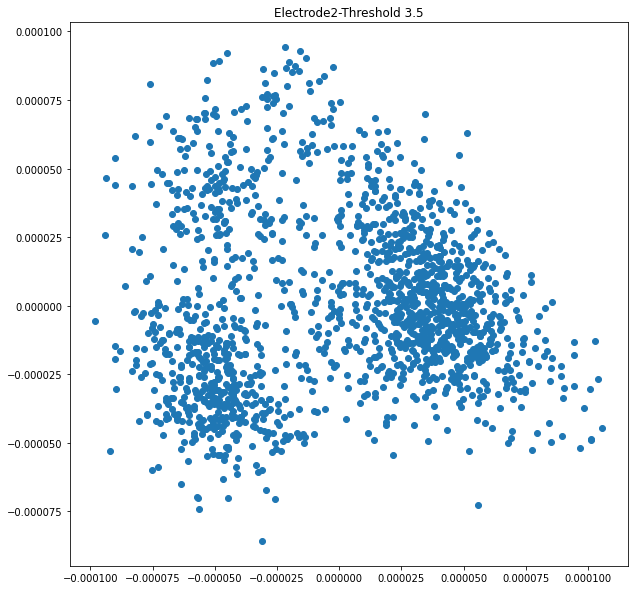

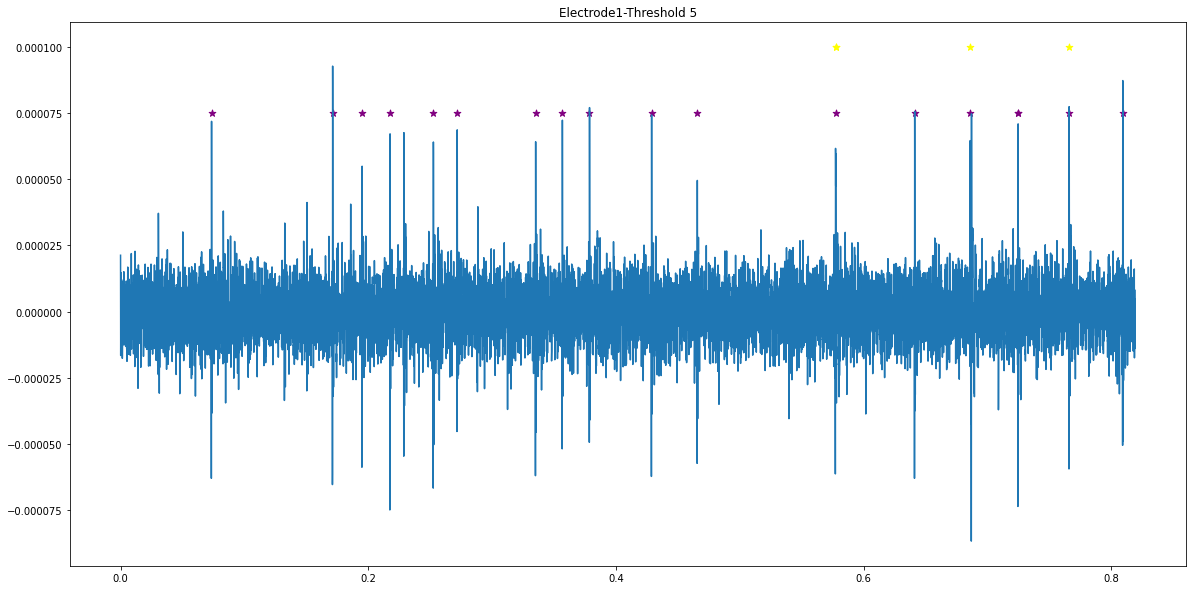

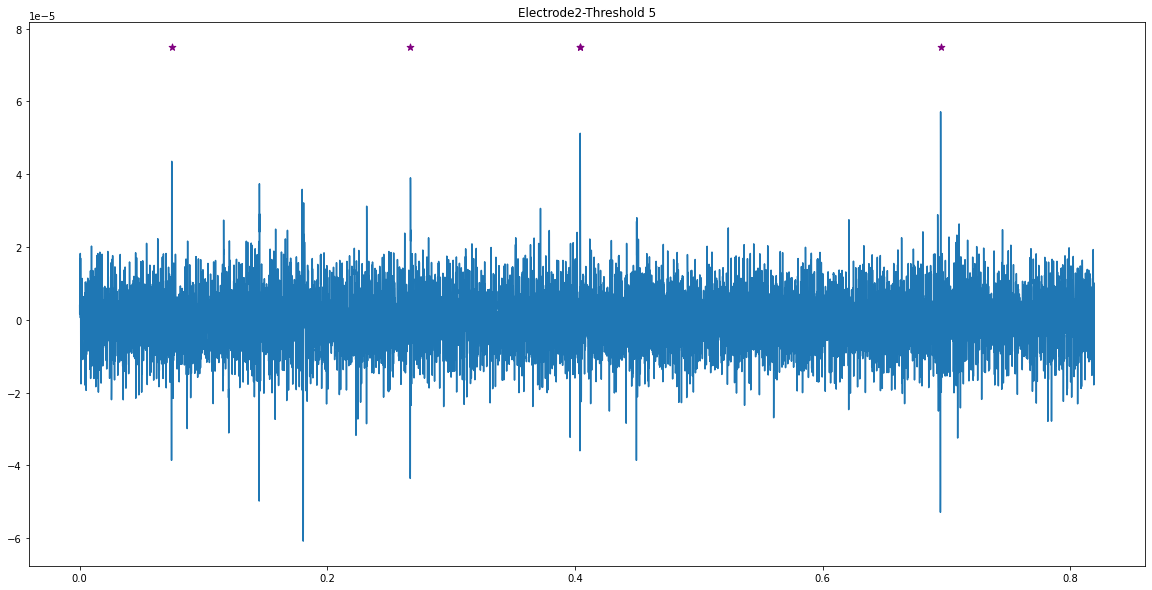

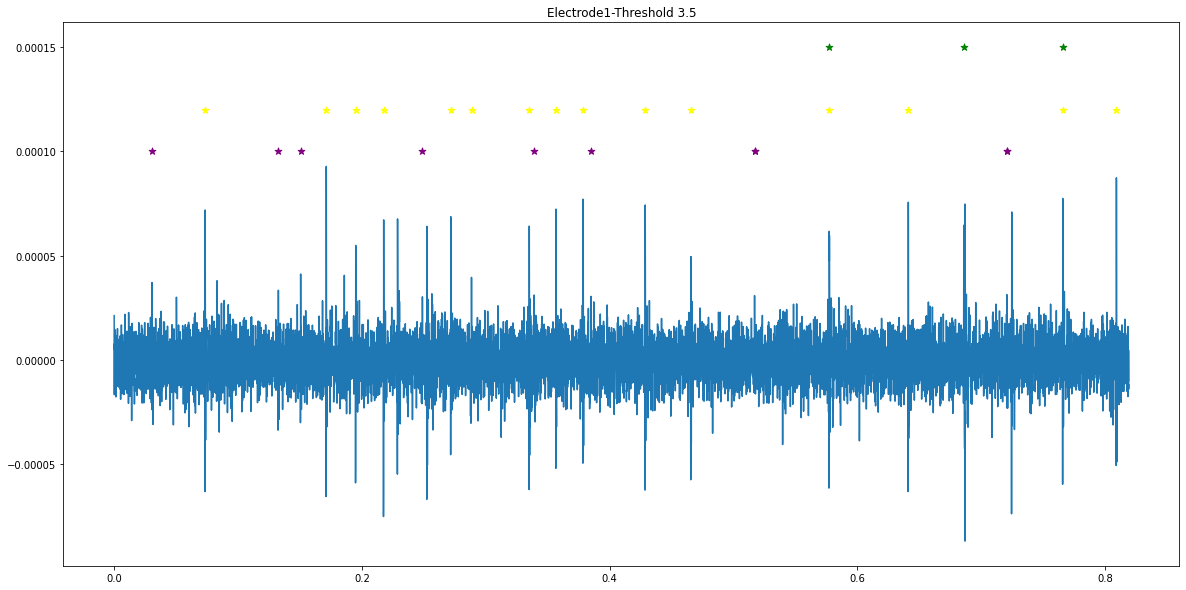

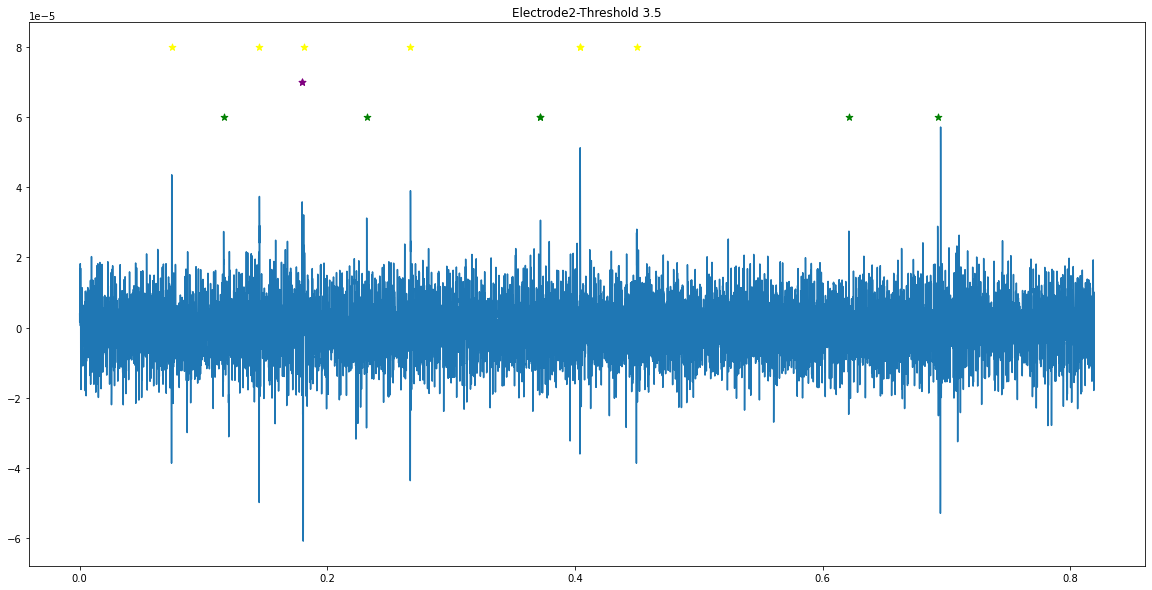

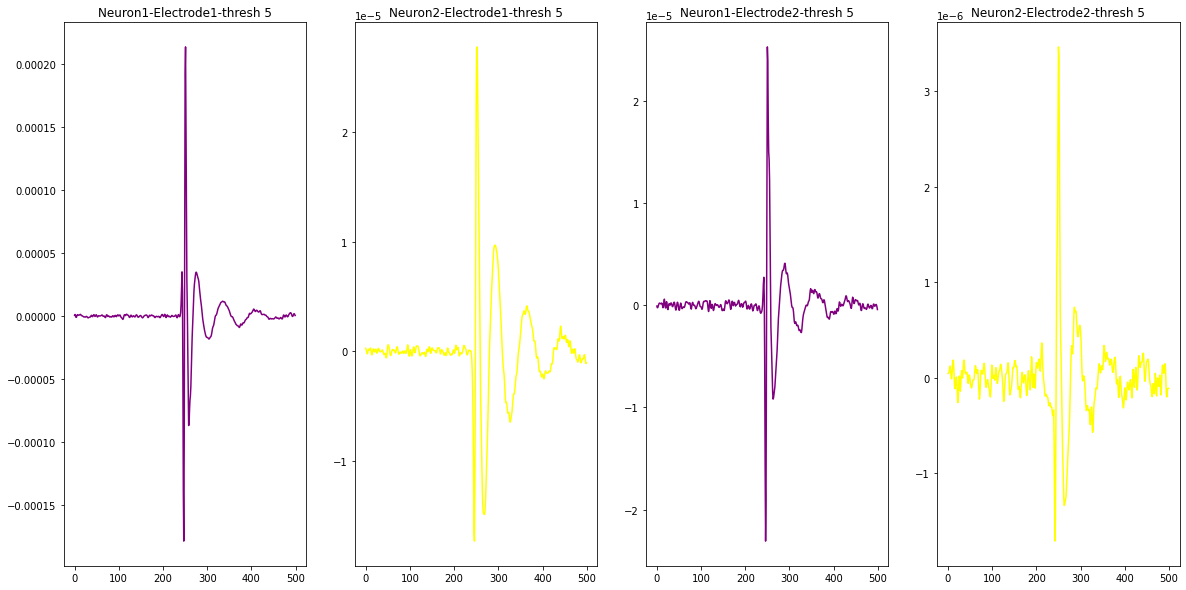

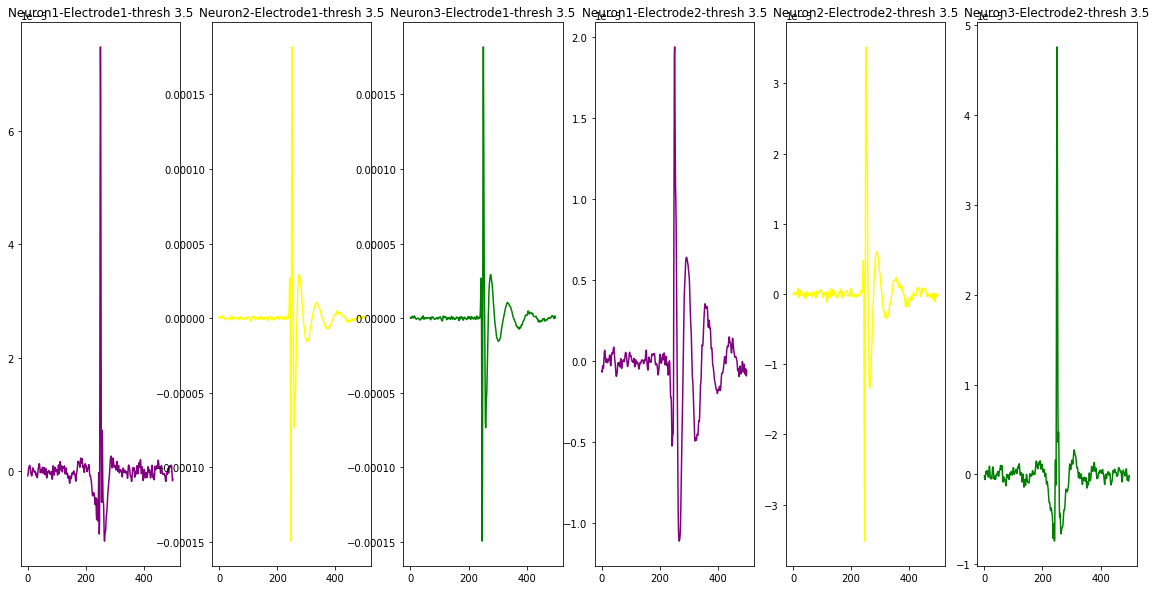

In [ ]:
MeanSpike, PeaksTimestamp = Spike_Sorting(electrode1, electrode2)